In [1]:
import os.path as osp

import numpy as np

import time

from general_tools.in_out.basics import files_in_subdirs

from geo_tool import Point_Cloud

from external_tools.binvox_rw.binvox_rw import read_as_3d_array

from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.autoencoder import AutoEncoder, Configuration

import tensorflow as tf

from general_tools.notebook.tf import reset_tf_graph

from tflearn.layers.conv import conv_3d, conv_3d_transpose

from tf_lab.data_sets.numpy_dataset import NumpyDataset

from tf_lab.in_out.basics import Data_Splitter

In [2]:
%matplotlib nbagg
%load_ext autoreload

In [5]:
from multiprocessing import Pool

def read_bin_vox_file(binvox_filename, perm_axis=(0,1,2), expand_last_dim=True, dtype=np.float32):
    with open(binvox_filename, 'rb') as f:
        vol = read_as_3d_array(f)
        
    vol = vol.data.astype(dtype)    
    vol = vol.transpose(perm_axis)    

    if expand_last_dim:
        vol = np.expand_dims(vol, vol.ndim)
    
    return vol

def read_shape_net_bin_vox(binvox_filename):
    tokens = binvox_filename.split('/')
    model_id = tokens[-2]
    class_id = tokens[-3]
    vol_grid = read_bin_vox_file(binvox_filename, perm_axis=(0,2,1))
    return vol_grid, model_id, class_id
    

def load_voxel_grids_from_filenames(file_names, n_threads=1, loader=read_shape_net_bin_vox, 
                                    verbose=False, dtype=np.float32):
    assert(len(file_names) > 1)
    voxel_grid, _, _ = loader(file_names[0])
    voxel_dims = list(voxel_grid.shape)    
    voxel_grids = np.empty([len(file_names)]+voxel_dims, dtype=dtype)
    model_names = np.empty([len(file_names)], dtype=object)
    class_ids = np.empty([len(file_names)], dtype=object)
    pool = Pool(n_threads)

    for i, data in enumerate(pool.imap(loader, file_names)):
        voxel_grids[i], model_names[i], class_ids[i] = data

    pool.close()
    pool.join()

    if len(np.unique(model_names)) != len(voxel_grids):
        warnings.warn('Point clouds with the same model name were loaded.')

    if verbose:
        print('{0} voxel-grids were loaded. They belong in {1} shape-classes.'.format(len(voxel_grids), len(np.unique(class_ids))))

    return voxel_grids, model_names, class_ids

In [21]:
top_data_dir = '/orions4-zfs/projects/optas/DATA'

class_name = 'chair'

syn_id = snc_category_to_synth_id()[class_name]

top_voxel_dir = osp.join(top_data_dir, 'Voxels/ShapeNetVox32')

splitter = Data_Splitter(top_voxel_dir, data_file_ending='.binvox')

splits = ['train', 'test']

in_data = dict()

for s in splits:
    split_file = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/' + syn_id + '/85_5_10/', s + '.txt')    
    data_in_split = splitter.load_splits(split_file, full_path=False)
    data_in_split_full_path = []
    for d in data_in_split:
        _, model_id = d.split('_')
        d_file = osp.join(top_voxel_dir, syn_id, model_id, 'model.binvox')
        data_in_split_full_path.append(d_file)
    voxel_grids, model_names, class_ids = load_voxel_grids_from_filenames(data_in_split_full_path, n_threads=10)
    in_data[s] = NumpyDataset([voxel_grids, class_ids + '_' + model_names], ['voxels', 'labels'])

['voxels', 'labels']
['voxels', 'labels']


In [49]:
from tflearn.layers.core import fully_connected

In [120]:
b_neck = 128

def three_d_conv_encoder(in_signal):
    layer = conv_3d(in_signal, nb_filter=32, filter_size=8, strides=4, activation='relu')
    layer = conv_3d(layer, nb_filter=64, filter_size=6, strides=4, activation='relu')
    layer = conv_3d(layer, nb_filter=128, filter_size=4, strides=2, activation='relu')    
    layer = conv_3d(layer, nb_filter=b_neck, filter_size=2, strides=1, activation='relu')
    return layer

def three_d_conv_decoder(in_signal):
    layer = conv_3d_transpose(in_signal, nb_filter=128, filter_size=2, strides=1, output_shape=[1,1,1], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=64, filter_size=4, strides=2, output_shape=[2,2,2], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=32, filter_size=8, strides=4, output_shape=[8,8,8], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=1, filter_size=8, strides=4, output_shape=[32,32,32], activation='linear')
    return layer

In [121]:
class Voxel_Based_AE(AutoEncoder):    
    def __init__(self, name, configuration, graph=None):
        c = configuration
        self.configuration = c
        AutoEncoder.__init__(self, name, graph, configuration)
        self.z = c.encoder(self.x)
        self.x_reconstr = c.decoder(self.z)
        self._create_loss()
        init = tf.global_variables_initializer() # TODO -> make part of Neural_Net
        self.start_session()

    def _create_loss(self):
        self.loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.x, logits=self.x_reconstr)
        self.loss = tf.reduce_mean(self.loss)
        self._setup_optimizer()
        
    def _setup_optimizer(self):
        c = self.configuration
        self.lr = c.learning_rate
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.loss)
        
    def _single_epoch_train(self, train_data, batch_size, only_fw=False):
        n_examples = train_data.n_examples
        epoch_loss = 0.
        n_batches = int(n_examples / batch_size)
        start_time = time.time()
        if only_fw:
            fit = self.reconstruct
        else:
            fit = self.partial_fit

        # Loop over all batches
        for _ in xrange(n_batches):
            batch_i, _ = train_data.next_batch(batch_size)
            _, loss = fit(batch_i)
            # Compute average loss
            epoch_loss += loss
        epoch_loss /= n_batches
        duration = time.time() - start_time
        return epoch_loss, duration

In [122]:
voxel_dims = list(in_data['train'].voxels.shape[1:])

conf = Configuration(n_input=voxel_dims, 
                     encoder=three_d_conv_encoder, 
                     decoder=three_d_conv_decoder,
                     learning_rate = 0.0005,
                    )

In [123]:
reset_tf_graph()
voxel_ae = Voxel_Based_AE('test_', conf)

In [124]:
max_epochs = 200
for i in range(1, max_epochs + 1):
    print i, voxel_ae._single_epoch_train(in_data['train'], batch_size=128)[0]
    if i % 10 == 0:
        print i, voxel_ae._single_epoch_train(in_data['test'], batch_size=128, only_fw=True)[0]

1 0.585070402755
2 0.255654733049
3 0.221581400434
4 0.202761602071
5 0.196422736843
6 0.181940926115
7 0.171119117406
8 0.167918988069
9 0.165352807111
10 0.162607784735
10 0.165145149827
11 0.157583855258
12 0.152766155865
13 0.146968519357
14 0.144090564383
15 0.144057956007
16 0.141290079554
17 0.139750245545
18 0.134702680839
19 0.132227391667
20 0.13029463109
20 0.135091209412
21 0.128242771824
22 0.126683567795
23 0.124204961459
24 0.123829341597
25 0.121205518643
26 0.119190546539
27 0.117241104444
28 0.11472480115
29 0.114996073312
30 0.111326166656
30 0.115378133953
31 0.111040239036
32 0.110216479335
33 0.108553808928
34 0.10640685608
35 0.106196599536
36 0.105801145236
37 0.104287779331
38 0.103924712208
39 0.101468027797
40 0.102093732357
40 0.107644978166
41 0.0979779856073
42 0.100872548918
43 0.0979402651389
44 0.09678629852
45 0.097197404835
46 0.0955324457751
47 0.0955469566915
48 0.0944668897324
49 0.092401361631
50 0.0920438241627
50 0.100520768762
51 0.091513184375

<IPython.core.display.Javascript object>


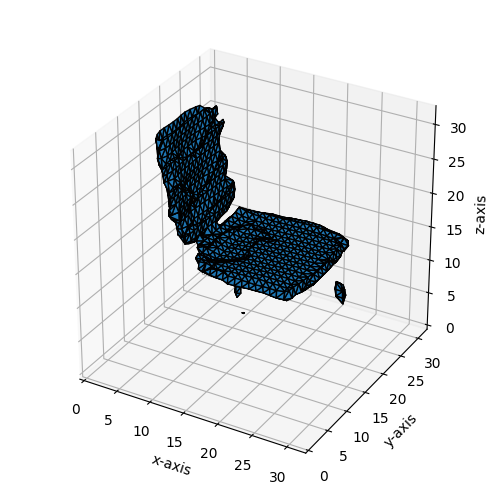

In [119]:
feed, _ = in_data['test'].next_batch(1)

recon_voxel = voxel_ae.reconstruct(feed)[0][0]
# recon_voxel = voxel_ae.sess.run(tf.sigmoid(recon_voxel))
recon_voxel = np.squeeze(recon_voxel)

iso_value = 0

# x, y, z = np.where(recon_voxel >= iso_value)
# Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False, azim=45);
plot_isosurface(recon_voxel, iso_value)

In [ ]:
# # yo = '/orions3-zfs/projects/msavva/zip/ShapeNetCore.v2/02691156/10155655850468db78d106ce0a280f87/models/model_normalized.solid.binvox'
# yo = '/orions3-zfs/projects/msavva/zip/ShapeNetCore.v1/02691156/10155655850468db78d106ce0a280f87/model.binvox'
# lala = read_single_bin_vox(yo, perm_axis=[0, 2, 1])
# print lala.shape
# lala = np.squeeze(lala)
# x, y, z = np.where(lala >= 0.5)
# Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False, azim=45);

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

def plot_isosurface(voxel_grid, iso_val=0):
    verts, faces, normals, values = measure.marching_cubes(voxel_grid, iso_val)
    x, y, z = zip(*verts)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    d0, d1, d2 = voxel_grid.shape
    ax.set_xlim(0, d0)
    ax.set_ylim(0, d1)
    ax.set_zlim(0, d2)
    plt.tight_layout()
    plt.show()